# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Import Necessary Packages

In [5]:
from collections import deque
from maddpg_agent import Agent
import numpy as np
import random
import time
import os
import torch
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

### 6. Create Agents

In [6]:
agent_0 = Agent(state_size, action_size, 1, 0)
agent_1 = Agent(state_size, action_size, 1, 0)

### 7. Define MADDPG Function For Training

In [7]:
def maddpg(n_episodes=7500, max_t=1000):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : Maximum number of training episodes
        max_t (int)           : Maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores_all = []
    mov_average = []
    best_score = -np.inf
    best_episode = 0
    solved = False    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]         # Reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # Get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            # choose agent actions and combine them
            action_0 = agent_0.act(states, add_noise=True)
            action_1 = agent_1.act(states, add_noise=True)
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            env_info = env.step(actions)[brain_name]           # Send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # Merge the agent next states
            rewards = env_info.rewards                         # Get reward
            done = env_info.local_done                         # See if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # Agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # Agent 2 learns
            scores += np.max(rewards)                          # Update the score for each agent
            states = next_states                               # Roll over states to next time step
            if np.any(done):                                   # Exit loop if episode finished
                break
        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        mov_average.append(np.mean(scores_window))
        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        
        if i_episode % 10 == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-10, i_episode, np.max(scores_all[-10:]), mov_average[-1]))
        # Determine if the environment is solved and save models
        if mov_average[-1] >= 0.5:
            if not solved:
                print('<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-100, mov_average[-1], 100))
                solved = True
                # Save the weights
                torch.save(agent_0.actor_local.state_dict(), 'actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'critic_1.pth')
            elif ep_best_score >= best_score:
                print('<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, mov_average[-1]))
                # Save the weights
                torch.save(agent_0.actor_local.state_dict(), 'actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'critic_1.pth')
            elif (i_episode-best_episode) >= 200:
                # Stop training if model stops converging
                print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
            
    return scores_all, mov_average

### 8. Train The Agents and Save The Scores

In [8]:
scores, moving_average = maddpg()

Episodes 0000-0010	Max Reward: 0.000	Moving Average: 0.000
Episodes 0010-0020	Max Reward: 0.100	Moving Average: 0.005
Episodes 0020-0030	Max Reward: 0.100	Moving Average: 0.013
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.013
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.014
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.017
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.017
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.016
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.017
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.018
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.019
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.022
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.024
Episodes 0130-0140	Max Reward: 0.300	Moving Average: 0.030
Episodes 0140-0150	Max Reward: 0.300	Moving Average: 0.033
Episodes 0150-0160	Max Reward: 0.100	Moving Average: 0.032
Episodes 0160-0170	Max Reward: 0.200	Moving Average: 0.0

Episodes 1280-1290	Max Reward: 5.300	Moving Average: 1.583
Episodes 1290-1300	Max Reward: 2.000	Moving Average: 1.650
Episodes 1300-1310	Max Reward: 0.600	Moving Average: 1.649
Episodes 1310-1320	Max Reward: 5.200	Moving Average: 1.704
Episodes 1320-1330	Max Reward: 5.200	Moving Average: 1.799
Episodes 1330-1340	Max Reward: 0.600	Moving Average: 1.707
Episodes 1340-1350	Max Reward: 0.900	Moving Average: 1.612
Episodes 1350-1360	Max Reward: 2.200	Moving Average: 1.428
Episodes 1360-1370	Max Reward: 0.800	Moving Average: 1.171
Episodes 1370-1380	Max Reward: 0.400	Moving Average: 0.856
Episodes 1380-1390	Max Reward: 0.600	Moving Average: 0.571
Episodes 1390-1400	Max Reward: 4.500	Moving Average: 0.568
Episodes 1400-1410	Max Reward: 5.200	Moving Average: 0.805
Episodes 1410-1420	Max Reward: 4.400	Moving Average: 0.805
Episodes 1420-1430	Max Reward: 5.100	Moving Average: 0.797
Episodes 1430-1440	Max Reward: 0.700	Moving Average: 0.792
Episodes 1440-1450	Max Reward: 3.500	Moving Average: 0.8

### 9. Plot The Scores

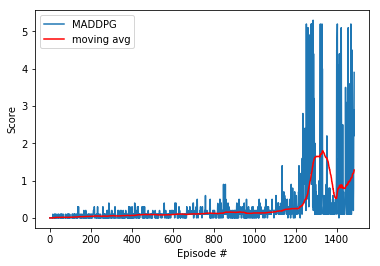

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), moving_average, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

### 10. Test The Saved Agents

In [10]:
# Load the weights from file
agent_0.actor_local.load_state_dict(torch.load('actor_0.pth'))
agent_1.actor_local.load_state_dict(torch.load('actor_1.pth')) 

In [11]:
def test_agents(n_episodes=10, max_t=1000, train_mode=False):
    scores_window = deque(maxlen=10)
    scores_all = []
    mov_average = []  
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]   # Reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # Get states and combine them
        scores = np.zeros(num_agents)
        while True:
            # choose agent actions and combine them
            action_0 = agent_0.act(states, add_noise=False)
            action_1 = agent_1.act(states, add_noise=False)
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            env_info = env.step(actions)[brain_name]           # Send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # Get the reward
            done = env_info.local_done                         # See if episode finished
            scores += np.max(rewards)                          # Update the score for each agent
            states = next_states                               # Roll over states to next time step
            if np.any(done):                                   # Exit loop if episode finished
                break
        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        mov_average.append(np.mean(scores_window))
        # print results
        if i_episode % 1 == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-1, i_episode, np.max(scores_all[-1:]), mov_average[-1]))
            
    return scores_all, mov_average   

In [12]:
scores, moving_average = test_agents()

Episodes 0000-0001	Max Reward: 5.200	Moving Average: 5.200
Episodes 0001-0002	Max Reward: 1.100	Moving Average: 3.150
Episodes 0002-0003	Max Reward: 5.200	Moving Average: 3.833
Episodes 0003-0004	Max Reward: 5.300	Moving Average: 4.200
Episodes 0004-0005	Max Reward: 5.200	Moving Average: 4.400
Episodes 0005-0006	Max Reward: 5.300	Moving Average: 4.550
Episodes 0006-0007	Max Reward: 0.000	Moving Average: 3.900
Episodes 0007-0008	Max Reward: 1.100	Moving Average: 3.550
Episodes 0008-0009	Max Reward: 5.200	Moving Average: 3.733
Episodes 0009-0010	Max Reward: 5.300	Moving Average: 3.890


### 11. Plot The Test Scores

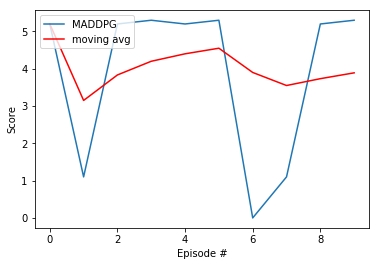

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), moving_average, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

### 11. Close The Environment

When finished, you can close the environment.

In [14]:
env.close()